In [1]:
import pymc as pm
import aesara.tensor as at

import numpy as np
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)
from multi_ouputs import build_XY, ICM, LCM, MultiMarginal
from mo import MultiOutputMarginal

# Different cases of multi-output GPs

All the cases below correspond to `gp.Latent`, but could be applied to `gp.Marginal` too.  

## 1. Multiple observations of the same GP, all at the same X values, no correlation between observations

- Y can be a matrix, each column (or row) of Y is an observation/output.  One X, same for each observation in Y.
- One kernel function, k(x, x'), shared by each output
- Each output or observation $y_i$ can be thought of as one draw from one GP, $y_i \sim N(0, K)$
- Simplest case.  GPy allows this out of the box, by just providing a matrix Y (pymc does not....)

(20,) (20, 3) (20, 20)


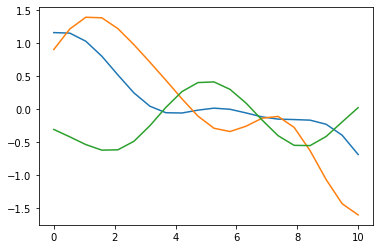

In [15]:
POINTS = 20
x = np.linspace(0, 10, POINTS)
K = pm.gp.cov.ExpQuad(1, ls=2)(x[:, None]).eval()

f = np.random.multivariate_normal(np.zeros(POINTS), K, 3).T

print(x.shape, f.shape, K.shape)
plt.plot(x, f);

In [17]:
x = x.reshape(-1,1)
X, Y, _ = build_XY([x,x,x], 
                   [f[:,0].reshape(-1,1), 
                    f[:,1].reshape(-1,1), 
                    f[:,2].reshape(-1,1)])
x.shape, X.shape, Y.shape

((20, 1), (60, 2), (60, 1))

In [18]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
    
    W = np.random.rand(2,2)
    B = at.dot(W, W.T)
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    mogp = MultiOutputMarginal(means=0, kernels=[cov], input_dim=2, active_dims=[1], num_outputs=3, W=W, B=B)
    y_ = mogp.marginal_likelihood("f", X, Y.squeeze(), noise=sigma)

In [19]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma, ICM_0_W, ICM_0_kappa]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 616 seconds.
There were 253 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


CPU times: user 26min 1s, sys: 55min 44s, total: 1h 21min 46s
Wall time: 10min 20s


In [23]:
with model:
    preds = mogp.conditional("preds2", X)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds2'], random_seed=42)

ValueError: the input matrix must be positive semidefinite
Apply node that caused the error: multivariate_normal_rv{1, (1, 2), floatX, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F79E7ED9820>), TensorConstant{[]}, TensorConstant{11}, BroadcastTo.0, Gemm{inplace}.0)
Toposort index: 27
Inputs types: [RandomGeneratorType, TensorType(int64, (0,)), TensorType(int64, ()), TensorType(float64, (None,)), TensorType(float64, (None, None))]
Inputs shapes: ['No shapes', (0,), (), (60,), (60, 60)]
Inputs strides: ['No strides', (8,), (), (8,), (480, 8)]
Inputs values: [Generator(PCG64) at 0x7F79E7ED9820, array([], dtype=int64), array(11), 'not shown', 'not shown']
Outputs clients: [['output'], ['output']]

HINT: Re-running with most Aesara optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the Aesara flag 'optimizer=fast_compile'. If that does not work, Aesara optimizations can be disabled with 'optimizer=None'.
HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(3,1, figsize=(8,12))

for idx in range(3):
    plot_gp_dist(axes[idx], f_pred[:,n_points*idx:n_points*(idx+1)], 
                 X_new[n_points*idx:n_points*(idx+1),0], 
                 palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
    axes[idx].plot(x, f[:,idx], 'ok', ms=3, alpha=0.5, label="Data 1");

## 2. Multiple observations of the same GP, different X values, no correlation between observations

- Basically the same scenario as above, but harder to write an API for.  Outputs and inputs will be different lengths

(20,) (20,) (20, 20)
(50,) (50,) (50, 50)
(100,) (100,) (100, 100)


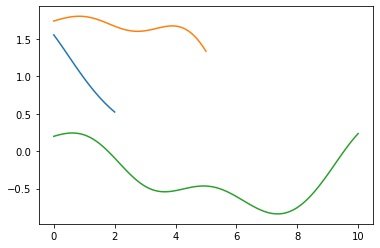

In [40]:
k = pm.gp.cov.ExpQuad(1, ls=2)

lengths = [20, 50, 100]

xs, fs = [], []
for i, length in enumerate(lengths):
    x = np.linspace(0, length / 10, length)
    K = k(x[:, None]).eval()
    
    f = np.random.multivariate_normal(np.zeros(length), K)
    xs.append(x.reshape(-1,1))
    fs.append(f.reshape(-1,1))
    print(x.shape, f.shape, K.shape)
    
    plt.plot(x, f)

In [41]:
X, Y, _ = build_XY(xs, fs)
x.shape, X.shape, Y.shape

((100,), (170, 2), (170, 1))

In [42]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=1)
    eta = pm.Gamma("eta", alpha=1, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
    
    W = np.random.rand(2,2)
    B = at.dot(W, W.T)
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    mogp = MultiOutputMarginal(means=0, kernels=[cov], input_dim=2, active_dims=[1], num_outputs=3, W=W, B=B)
    y_ = mogp.marginal_likelihood("f", X, Y.squeeze(), noise=sigma)

In [ ]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma, ICM_0_W, ICM_0_kappa]


In [ ]:
with model:
    preds = mogp.conditional("preds2", X)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds2'], random_seed=42)

In [ ]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(3,1, figsize=(8,12))

for idx in range(3):
    plot_gp_dist(axes[idx], f_pred[:,n_points*idx:n_points*(idx+1)], 
                 X_new[n_points*idx:n_points*(idx+1),0], 
                 palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
    axes[idx].plot(x, f[:,idx], 'ok', ms=3, alpha=0.5, label="Data 1");

## 3. Multiple observations, same X values, correlation between outputs from arbitrary K (Kronecker)
 
Can use Kronecker here because we have the same x values.   Using $o$ and $o'$ for "output".  I think this is the same as ICM?, except in ICM $K_2$ has that specific structure.

$$
K = K_1(x, x') \otimes K_2(o, o')
$$

What is critical about the Kronecker product, is that when we implement the GP, we don't have to actually compute $\otimes$. This is because
$$
(K_1 \otimes K_2)^{-1} = K_1^{-1} \otimes K_2^{-1}
$$
which is a huge computational speed up.  It makes a lot of datasets possible that weren't before. 

Examples: https://docs.pymc.io/en/v3/pymc-examples/examples/gaussian_processes/GP-Kron.html

## 4. Multiple observations, *different* X values for each output, correlation between outputs from arbitrary K (cant exploit Kronecker)
 
Using $o$ and $o'$ for "output".  Need to use Hadamard product here, I think there aren't computational speedups available here.  $ K_2(o, o')$ needs to be indexed to the right size.

$$
K = K_1(x, x')  K_2(o, o')
$$

ICM, LCM are special cases of this, depending on how you set $K_2$.  No examples because I think this is where you've spent the most time and know it well.

## 5. Hierarchical.  Not terribly common, but I've seen it a few times in the wild.  This is the generalization of a hierarchical model to GPs.

One GP is the mean of the other GPs, giving the same "shrinkage" effect as in a hierarchical bayesian model.  Similar speedups should be available depending on whether each GP is observed at every input X.  Heres a paper by the GPflow people https://bmcbioinformatics.biomedcentral.com/track/pdf/10.1186/1471-2105-14-252.pdf   

(100,) (100, 100) (100,) (100, 3)


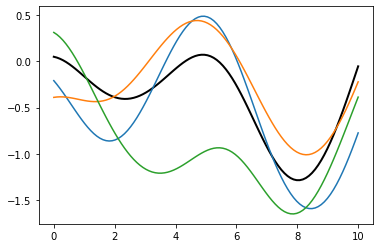

In [12]:
## observed at every X

x = np.linspace(0, 10, 100)
K = pm.gp.cov.ExpQuad(1, ls=2)(x[:, None]).eval()

f_global = np.random.multivariate_normal(np.zeros(100), K, 1).flatten()

f = np.random.multivariate_normal(f_global, 0.2 * K, 3).T

print(x.shape, K.shape, f_global.shape, f.shape)
plt.plot(x, f_global, color="k", lw=2);
plt.plot(x, f);

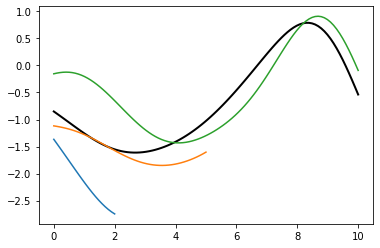

In [13]:
## NOT observed at every X

x = np.linspace(0, 10, 100)
k = pm.gp.cov.ExpQuad(1, ls=2)
f_global = np.random.multivariate_normal(np.zeros(100), k(x[:, None]).eval(), 1).flatten()

plt.plot(x, f_global, color="k", lw=2);

lengths = [20, 50, 100]
for i, length in enumerate(lengths):
    x = np.linspace(0, length / 10, length)
    K = k(x[:, None]).eval()
    
    f = np.random.multivariate_normal(f_global[:length], 0.2 * k(x[:, None]).eval())
    
    plt.plot(x, f)

## Other thoughts:

- Big distinction between whether each output has the same number of observations, at the same X values.  If each Y is the same length, and each output in Y is observed for each X, the user can pass in a matrix Y, and a single X matrix.  No need for an output index to be in X (or elsewhere).  
- Aesara doesnt have ragged arrays, so different length outputs cant be put into a matrix together.  Two ways to handle this is to output either a list of Y, or stack Y into a tall vector, and have a way to index each output. The second option probably fits in better with the way indexing is done in most models already, so will be most familiar to users.
- These are all exact GPs.  The simplest (though they are not simple) approximations are based on inducing points.  Paper here: https://arxiv.org/pdf/2003.01115.pdf.  This is probably out of scope, but want to mention it.  

Possible API, something like this?: 
```
mogp = pm.gp.MultiOutputLatent(mean_func=mu, cov_func_input=cov_x, cov_func_output=cov_o)
f = mogp.prior("f", X=X, output_index=output_index)
```
I havent thought this through very far, it may not make sense, or may not make sense in all cases, like hierarchical. its pretty similar to the existing api though. 